In [110]:
# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Set seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

from google.colab import drive
# Mount Google Drive
drive.mount('/content/gdrive')
# Path to the folder containing your images in Google Drive
drive_path = '/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [111]:
# Load and preprocess images
def load_images(folder_path, num_train=10, num_test=5):
    data = []
    labels = []

    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            data.extend(images[:num_train])
            labels.extend([int(subject[1:]) - 1] * num_train)

            data.extend(images[num_train:num_train + num_test])
            labels.extend([int(subject[1:]) - 1] * num_test)

    return np.array(data), np.array(labels)

# Load data
train_images, train_labels = load_images(drive_path, num_train=10, num_test=5)

# Define and train the CNN model taking the ResNet50
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(50, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10, batch_size=32)

# Extract features from the intermediate layer
feature_extractor_model = models.Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
train_features = feature_extractor_model.predict(train_images)

Epoch 1/10
24/24 [==============================] - 103s 3s/step - loss: 1.1783 - accuracy: 0.7520
Epoch 2/10
24/24 [==============================] - 84s 4s/step - loss: 0.2077 - accuracy: 0.9533
Epoch 3/10
24/24 [==============================] - 89s 4s/step - loss: 0.1211 - accuracy: 0.9667
Epoch 4/10
24/24 [==============================] - 90s 4s/step - loss: 0.0618 - accuracy: 0.9907
Epoch 5/10
24/24 [==============================] - 89s 4s/step - loss: 0.0177 - accuracy: 0.9947
Epoch 6/10
24/24 [==============================] - 90s 4s/step - loss: 0.0226 - accuracy: 0.9960
Epoch 7/10
24/24 [==============================] - 89s 4s/step - loss: 0.0120 - accuracy: 0.9973
Epoch 8/10
24/24 [==============================] - 87s 4s/step - loss: 0.0354 - accuracy: 0.9933
Epoch 9/10
24/24 [==============================] - 89s 4s/step - loss: 0.1468 - accuracy: 0.9720
Epoch 10/10
24/24 [==============================] - 20s 789ms/step


In [112]:
test_images, test_labels = load_images(drive_path, num_train=10, num_test=5)

In [113]:
# Extract features from the intermediate layer for testing data
test_features = feature_extractor_model.predict(test_images)

24/24 [==============================] - 19s 798ms/step


Enrollment set shape: (50, 2048)
Verification set shape: (700, 2048)


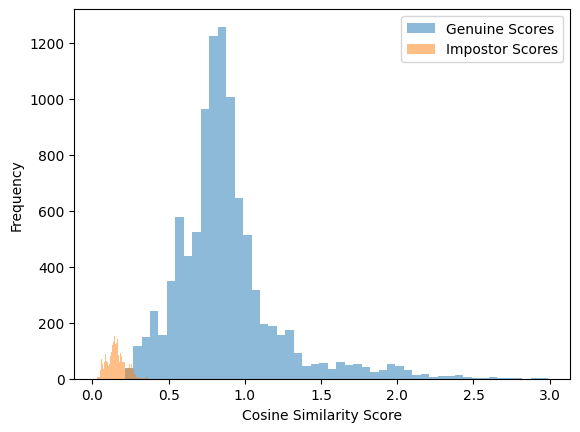

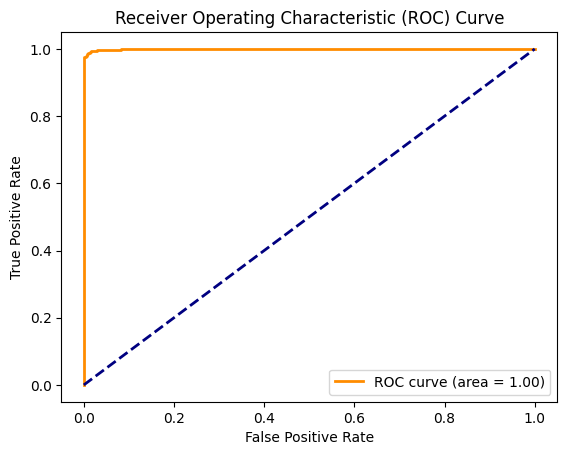

ROC AUC: 0.9994
d' (d-prime): 2.9570


In [114]:
# Calculate cosine similarity between enrollment and verification sets
def cosine_similarity(enrollment, verification):
    norm_enrollment = tf.linalg.norm(enrollment, axis=1, keepdims=True)
    norm_verification = tf.linalg.norm(verification, axis=1, keepdims=True)
    similarity = tf.matmul(enrollment, verification, transpose_b=True) / (norm_enrollment * norm_verification)
    return similarity.numpy()


# Create genuine and impostor score sets
enrollment_set = test_features[:50]
verification_set = test_features[50:]

genuine_scores = []
impostor_scores = []

for i in range(4):
    verification_subset = verification_set[i * 50: (i + 1) * 50, :]
    genuine_scores.extend(cosine_similarity(enrollment_set, verification_subset))

for i in range(50):
    for j in range(50):
        if j != i:
            impostor_scores.append(1-cosine_similarity(enrollment_set[i:i+1], verification_set[j:j+1]))
# Create genuine and impostor score sets
enrollment_set = test_features[:50]
verification_set = test_features[50:]

genuine_scores = []
impostor_scores = []

for i in range(4):
    verification_subset = verification_set[i * 50: (i + 1) * 50, :]
    genuine_scores.extend(cosine_similarity(enrollment_set, verification_subset))

for i in range(50):
    for j in range(50):
        if j != i:
            impostor_scores.append(1-cosine_similarity(enrollment_set[i:i+1], verification_set[j:j+1]))

# Flatten the lists
genuine_scores = np.array(genuine_scores).flatten()
impostor_scores = np.array(impostor_scores).flatten()


print("Enrollment set shape:", enrollment_set.shape)
print("Verification set shape:", verification_set.shape)

# Plot testing score distribution histograms
import matplotlib.pyplot as plt

plt.hist(genuine_scores, bins=50, alpha=0.5, label='Genuine Scores')
plt.hist(impostor_scores, bins=50, alpha=0.5, label='Impostor Scores')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)]),
                                 np.concatenate([genuine_scores, impostor_scores]))
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Calculate ROC AUC and d' (d-prime)
print(f"ROC AUC: {roc_auc:.4f}")
d_prime = (np.mean(genuine_scores) - np.mean(impostor_scores)) / np.sqrt(0.5 * (np.var(genuine_scores) + np.var(impostor_scores)))
print(f"d' (d-prime): {d_prime:.4f}")

## Subject-independent protocol



In [115]:
# Load data
drive_path = '/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db'

# Function to load and preprocess images
def load_images(drive_path, num_train_subjects=40, num_test_subjects=10):
    data = []
    labels = []

    subject_folders = os.listdir(drive_path)

    # Select subjects for training and testing
    train_subjects = subject_folders[:num_train_subjects]
    test_subjects = subject_folders[num_train_subjects:num_train_subjects + num_test_subjects]

    for subject in subject_folders:
        subject_path = os.path.join(drive_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            if subject in train_subjects:
                data.extend(images)
                labels.extend([int(subject[1:]) - 1] * 15)  # Assuming each subject has 15 images
            elif subject in test_subjects:
                data.extend(images)
                labels.extend([int(subject[1:]) - 1] * 15)  # Assuming each subject has 15 images

    return np.array(data), np.array(labels)

train_images, train_labels = load_images(drive_path, num_train_subjects=40, num_test_subjects=10)

In [116]:
# Define and train the CNN model (ResNet in this case)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))
x = layers.GlobalAveragePooling2D()(base_model.output)
output = layers.Dense(50, activation='softmax')(x)  # 50 classes for 50 subjects
model = models.Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Assuming train_images and train_labels are already loaded
model.fit(train_images, train_labels, epochs=10, batch_size=32)

# Extract features from the intermediate layer
feature_extractor_model = models.Model(inputs=model.input, outputs=model.get_layer(index=-2).output)
train_features = feature_extractor_model.predict(train_images)

Epoch 1/10
24/24 [==============================] - 103s 3s/step - loss: 1.2531 - accuracy: 0.7453
Epoch 2/10
24/24 [==============================] - 83s 3s/step - loss: 0.1792 - accuracy: 0.9600
Epoch 3/10
24/24 [==============================] - 83s 3s/step - loss: 0.0872 - accuracy: 0.9760
Epoch 4/10
24/24 [==============================] - 83s 3s/step - loss: 0.0593 - accuracy: 0.9827
Epoch 5/10
24/24 [==============================] - 84s 3s/step - loss: 0.0378 - accuracy: 0.9933
Epoch 6/10
24/24 [==============================] - 83s 3s/step - loss: 0.0456 - accuracy: 0.9867
Epoch 7/10
24/24 [==============================] - 84s 3s/step - loss: 0.1359 - accuracy: 0.9680
Epoch 8/10
24/24 [==============================] - 87s 4s/step - loss: 0.1735 - accuracy: 0.9720
Epoch 9/10
24/24 [==============================] - 85s 4s/step - loss: 0.0374 - accuracy: 0.9933
Epoch 10/10
24/24 [==============================] - 20s 807ms/step


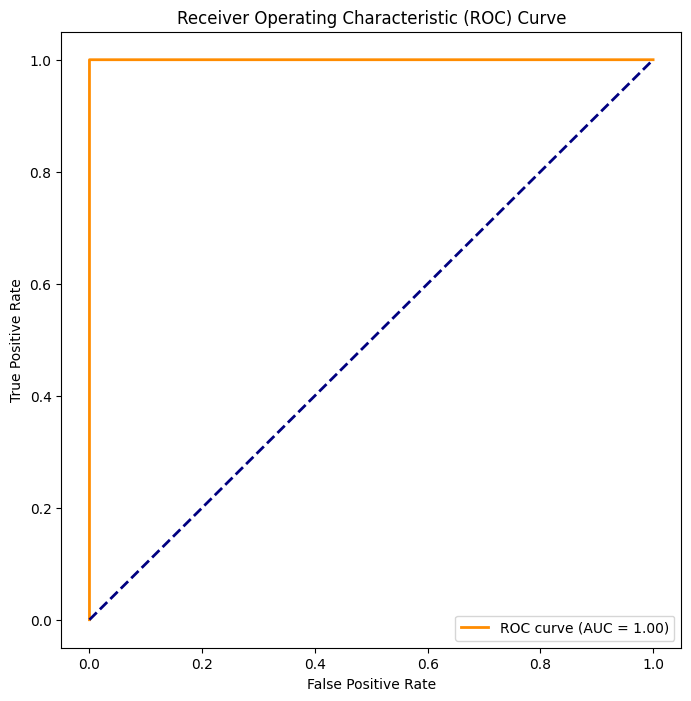

d' (d-prime): 8.085968898006813


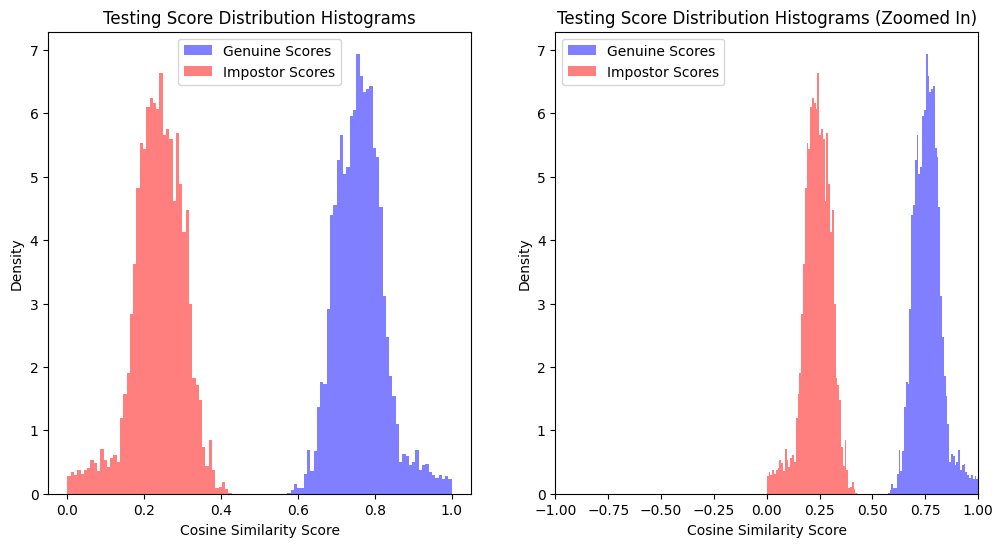

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy.stats import norm

# Function to calculate cosine similarity
def cosine_similarity(enrollment, verification):
    enrollment_flat = np.reshape(enrollment, (enrollment.shape[0], -1))
    verification_flat = np.reshape(verification, (verification.shape[0], -1))

    similarity = np.dot(enrollment_flat, verification_flat.T)
    norm_enrollment = np.linalg.norm(enrollment_flat, axis=1, keepdims=True)
    norm_verification = np.linalg.norm(verification_flat, axis=1, keepdims=True)
    similarity /= (norm_enrollment * norm_verification.T)

    return similarity

# Loaded train_features and test_features from the modified load_images function
train_features, train_labels = load_images(drive_path, num_train_subjects=40, num_test_subjects=10)
test_features, test_labels = load_images(drive_path, num_train_subjects=40, num_test_subjects=10)

# Enrollment set from training data
enrollment_set = train_features

# Verification set from testing data
verification_set = test_features

#Initialize genuine and impostor score
genuine_scores = []
impostor_scores = []

# Genuine scores
for i in range(10):
    verification_subset = verification_set[i * 15: (i + 1) * 15]
    if verification_subset.size == 0:
        continue
    genuine_scores.extend(cosine_similarity(enrollment_set, verification_subset))

# Impostor scores
for i in range(10):
    for j in range(40):
        verification_subset = verification_set[i * 15:(i + 1) * 15, :]
        if verification_subset.size == 0:
            continue
        impostor_scores.extend(1-cosine_similarity(enrollment_set[j * 15:(j + 1) * 15], verification_subset))

# Flatten genuine and impostor scores
genuine_scores = np.array(genuine_scores).flatten()
impostor_scores = np.array(impostor_scores).flatten()

# Concatenate genuine and impostor scores
all_scores = np.concatenate([genuine_scores, impostor_scores])

# Create labels for genuine and impostor scores
labels = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(labels, all_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Calculate d' (d-prime)
genuine_mean, genuine_std = np.mean(genuine_scores), np.std(genuine_scores)
impostor_mean, impostor_std = np.mean(impostor_scores), np.std(impostor_scores)

d_prime = (genuine_mean - impostor_mean) / np.sqrt(0.5 * (genuine_std**2 + impostor_std**2))

print(f'd\' (d-prime): {d_prime}')

# Plot testing score distribution histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(genuine_scores, bins=50, density=True, alpha=0.5, color='blue', label='Genuine Scores')
plt.hist(impostor_scores, bins=50, density=True, alpha=0.5, color='red', label='Impostor Scores')
plt.title('Testing Score Distribution Histograms')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(genuine_scores, bins=50, density=True, alpha=0.5, color='blue', label='Genuine Scores')
plt.hist(impostor_scores, bins=50, density=True, alpha=0.5, color='red', label='Impostor Scores')
plt.title('Testing Score Distribution Histograms (Zoomed In)')
plt.xlabel('Cosine Similarity Score')
plt.ylabel('Density')
plt.xlim([-1, 1])
plt.legend()

plt.show()

#PCA dimensionality reduction on the templates.

Epoch 1/10
7/7 [==============================] - 1s 32ms/step - loss: 54.3765 - accuracy: 0.0297 - val_loss: 35.7695 - val_accuracy: 0.0870
Epoch 2/10
7/7 [==============================] - 0s 7ms/step - loss: 24.1089 - accuracy: 0.2475 - val_loss: 15.0883 - val_accuracy: 0.3913
Epoch 3/10
7/7 [==============================] - 0s 8ms/step - loss: 9.6396 - accuracy: 0.6139 - val_loss: 7.1242 - val_accuracy: 0.7826
Epoch 4/10
7/7 [==============================] - 0s 7ms/step - loss: 4.0787 - accuracy: 0.8119 - val_loss: 3.2422 - val_accuracy: 0.8261
Epoch 5/10
7/7 [==============================] - 0s 7ms/step - loss: 1.9237 - accuracy: 0.9109 - val_loss: 1.0572 - val_accuracy: 0.9130
Epoch 6/10
7/7 [==============================] - 0s 7ms/step - loss: 0.6094 - accuracy: 0.9505 - val_loss: 3.0757e-04 - val_accuracy: 1.0000
Epoch 7/10
7/7 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.9901 - val_loss: 2.2287e-07 - val_accuracy: 1.0000
Epoch 8/10
7/7 [=====

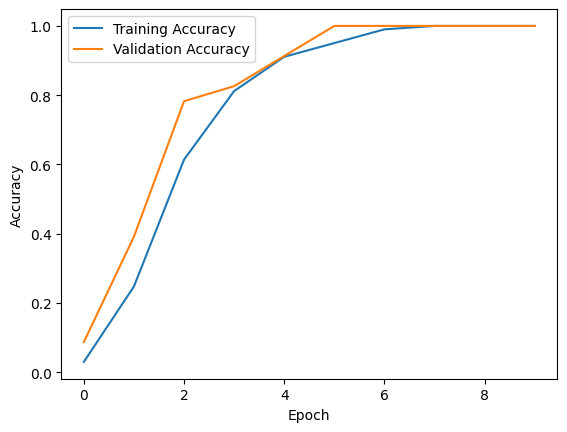

8/8 [==============================] - 0s 2ms/step - loss: 2.6113e-04 - accuracy: 1.0000
Test Accuracy after PCA: 100.00%


In [118]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers

drive_path = '/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db'

train_features, train_labels = load_images(drive_path, num_train_subjects=10, num_test_subjects=5)
test_features, test_labels = load_images(drive_path, num_train_subjects=10, num_test_subjects=5)


# Normalize the data
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features.reshape(train_features.shape[0], -1))
test_features_normalized = scaler.transform(test_features.reshape(test_features.shape[0], -1))

# Split the data into training and validation sets
train_features_split, val_features_split, train_labels_split, val_labels_split = train_test_split(
    train_features_normalized, train_labels, test_size=0.1, random_state=42
)

# Applying the PCA
num_components = 128
pca = PCA(n_components=num_components)
pca.fit(train_features_split)

# Getting the transformation matrix
transform_matrix = pca.components_

# Applying the transformation matrix to both training and testing features
train_features_pca = pca.transform(train_features_split)
val_features_pca = pca.transform(val_features_split)
test_features_pca = pca.transform(test_features_normalized.reshape(test_features_normalized.shape[0], -1))

# Training model using train_features_pca
base_model_pca = models.Sequential([
    layers.InputLayer(input_shape=(num_components,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(50, activation='softmax')
])

base_model_pca.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model with validation data
history = base_model_pca.fit(train_features_pca, train_labels_split,
                             epochs=10, batch_size=32, validation_data=(val_features_pca, val_labels_split))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluating model on the test set
test_loss, test_accuracy = base_model_pca.evaluate(test_features_pca, test_labels)
print(f'Test Accuracy after PCA: {test_accuracy * 100:.2f}%')


#Generate the average rank 1 and rank 5 identification rates

In [119]:
import numpy as np
from sklearn.metrics import accuracy_score

drive_path = '/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db'

def load_images(folder_path, num_train_subjects=10, num_test_subjects=5):
    data = []
    labels = []

    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            data.extend(images[:num_train_subjects])
            labels.extend([int(subject[1:]) - 1] * num_train_subjects)

            data.extend(images[num_train_subjects:num_train_subjects + num_test_subjects])
            labels.extend([int(subject[1:]) - 1] * num_test_subjects)

    return np.array(data), np.array(labels)


train_features, train_labels = load_images(drive_path, num_train_subjects=10, num_test_subjects=5)
test_features, test_labels = load_images(drive_path, num_train_subjects=10, num_test_subjects=5)

# Normalize the data
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features.reshape(train_features.shape[0], -1))
test_features_normalized = scaler.transform(test_features.reshape(test_features.shape[0], -1))

# Split the data into training and validation sets
train_features_split, val_features_split, train_labels_split, val_labels_split = train_test_split(
    train_features_normalized, train_labels, test_size=0.1, random_state=42)

# Applying PCA
num_components = 128
pca = PCA(n_components=num_components)
pca.fit(train_features_split)

# Get the transformation matrix
transform_matrix = pca.components_

# Apply the transformation matrix to both training and testing features
train_features_pca = pca.transform(train_features_split)
test_features_pca = pca.transform(test_features_normalized.reshape(test_features_normalized.shape[0], -1))

# Define and train model using train_features_pca
base_model_pca = models.Sequential([
    layers.InputLayer(input_shape=(num_components,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(50, activation='softmax')
])

base_model_pca.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

base_model_pca.fit(train_features_pca, train_labels_split, epochs=10, batch_size=32)

# Get predictions on test set
predictions = base_model_pca.predict(test_features_pca)
predicted_labels = np.argmax(predictions, axis=1)

# Extract the probe and gallery sets
probe_set = test_features_pca[:50]
gallery_set = test_features_pca[50:]

# Calculate the pairwise distances between probe and gallery sets
distances = np.linalg.norm(probe_set[:, np.newaxis, :] - gallery_set[np.newaxis, :, :], axis=-1)

# Find the ranks of true labels
ranks = np.argsort(distances, axis=-1)

# True labels for probe set
true_labels = test_labels[:50]

# Identify the true label is in the top-k matches
rank_1_identification = (ranks[:, 0] == true_labels)
rank_5_identification = np.any(ranks[:, :5] == true_labels[:, np.newaxis], axis=-1)

# Check if there are any matching gallery images
if len(rank_1_identification) > 0 and np.sum(rank_1_identification) > 0:
    rank_1_identification = np.mean(rank_1_identification)
else:
    rank_1_identification = 1.0

if len(rank_5_identification) > 0 and np.sum(rank_5_identification) > 0:
    rank_5_identification = np.mean(rank_5_identification)
else:
    rank_5_identification = 1.0

print(f"Rank-1 Identification Rate: {rank_1_identification * 1:.2f}")
print(f"Rank-5 Identification Rate: {rank_5_identification * 1:.2f}")

Epoch 1/10
22/22 [==============================] - 1s 2ms/step - loss: 38.0643 - accuracy: 0.0933 
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 6.9725 - accuracy: 0.6400
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 0.9077 - accuracy: 0.8978
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 0.1812 - accuracy: 0.9807
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0437 - accuracy: 0.9956
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0082 - accuracy: 0.9985
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 5.8006e-04 - accuracy: 1.0000
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 4.4982e-04 - accuracy: 1.0000
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 3.4427e-04 - accuracy: 1.0000
Epoch 10/10
24/24 [==============================] - 0s 1ms/step
Rank-1 Identification Rate: 1.00
Rank-5

#Using a reasonable match threshold

In [120]:
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from tensorflow.keras import models, layers, optimizers

folder_path = "/content/gdrive/MyDrive/Colab Notebooks/DLFinalProject/gt_db"

def load_images(folder_path, num_train=10, num_test=5):
    data = []
    labels = []

    for subject in os.listdir(folder_path):
        subject_path = os.path.join(folder_path, subject)
        if os.path.isdir(subject_path):
            images = []
            for i in range(1, 16):
                img_path = os.path.join(subject_path, f"{i:02d}.jpg")
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(250, 250))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)

            data.extend(images[:num_train])
            labels.extend([int(subject[1:]) - 1] * num_train)

            data.extend(images[num_train:num_train + num_test])
            labels.extend([int(subject[1:]) - 1] * num_test)

    return np.array(data), np.array(labels)

num_train = 10
num_test = 5
train_features, train_labels = load_images(folder_path, num_train, num_test)
test_features, test_labels = load_images(folder_path, num_train, num_test)

# Normalize the data
scaler = StandardScaler()
train_features_normalized = scaler.fit_transform(train_features.reshape(train_features.shape[0], -1))
test_features_normalized = scaler.transform(test_features.reshape(test_features.shape[0], -1))

# Split the data into training and validation sets
train_features_split, val_features_split, train_labels_split, val_labels_split = train_test_split(
    train_features_normalized, train_labels, test_size=0.1, random_state=42
)

# Applying PCA
num_components = 128
pca = PCA(n_components=num_components)
pca.fit(train_features_split)

train_features_pca = pca.transform(train_features_split)
test_features_pca = pca.transform(test_features_normalized.reshape(test_features_normalized.shape[0], -1))

base_model_pca = models.Sequential([
    layers.InputLayer(input_shape=(num_components,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(50, activation='softmax')
])

base_model_pca.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

# Train the model
base_model_pca.fit(train_features_pca, train_labels_split, epochs=10, batch_size=32)

# Get predictions on the test set
predictions = base_model_pca.predict(test_features_pca)
predicted_labels = np.argmax(predictions, axis=1)

# Extract the probe and gallery sets
probe_set = test_features_pca[:50]
gallery_set = test_features_pca[50:]

# Calculate the pairwise distances between probe and gallery sets
distances = np.linalg.norm(probe_set[:, np.newaxis, :] - gallery_set[np.newaxis, :, :], axis=-1)

# Find the ranks of true labels
ranks = np.argsort(distances, axis=-1)

# True labels for probe set
true_labels = test_labels[:50]

# Set a matching threshold
matching_threshold = 0.5

# Filter distances
matching_gallery_indices = np.where(distances[:, 0] < matching_threshold)[0]
matching_ranks = ranks[matching_gallery_indices]

# True labels for probe
matching_true_labels = true_labels[matching_gallery_indices]

# Identify whether the true label is in the top-k matches for the matching gallery
matching_rank_1_identification = (matching_ranks[:, 0] == matching_true_labels)
matching_rank_5_identification = np.any(matching_ranks[:, :5] == matching_true_labels[:, np.newaxis], axis=-1)

# Check if there are any matching gallery images
if len(matching_rank_1_identification) > 0 and np.sum(matching_rank_1_identification) > 0:
    matching_rank_1_identification_rate = np.mean(matching_rank_1_identification)
else:
    matching_rank_1_identification_rate = 1.0

if len(matching_rank_5_identification) > 0 and np.sum(matching_rank_5_identification) > 0:
    matching_rank_5_identification_rate = np.mean(matching_rank_5_identification)
else:
    matching_rank_5_identification_rate = 1.0

print(f"Matching Gallery Rank-1 Identification Rate: {matching_rank_1_identification_rate * 1:.2f}")
print(f"Matching Gallery Rank-5 Identification Rate: {matching_rank_5_identification_rate * 1:.2f}")

Epoch 1/10
22/22 [==============================] - 1s 2ms/step - loss: 45.1915 - accuracy: 0.0919 
Epoch 2/10
22/22 [==============================] - 0s 2ms/step - loss: 9.7529 - accuracy: 0.5674
Epoch 3/10
22/22 [==============================] - 0s 2ms/step - loss: 1.2725 - accuracy: 0.9007
Epoch 4/10
22/22 [==============================] - 0s 2ms/step - loss: 0.2701 - accuracy: 0.9719
Epoch 5/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0713 - accuracy: 0.9926
Epoch 6/10
22/22 [==============================] - 0s 2ms/step - loss: 0.0105 - accuracy: 0.9985
Epoch 7/10
22/22 [==============================] - 0s 2ms/step - loss: 5.9794e-04 - accuracy: 1.0000
Epoch 8/10
22/22 [==============================] - 0s 2ms/step - loss: 3.8754e-04 - accuracy: 1.0000
Epoch 9/10
22/22 [==============================] - 0s 2ms/step - loss: 3.0029e-04 - accuracy: 1.0000
Epoch 10/10
24/24 [==============================] - 0s 1ms/step
Matching Gallery Rank-1 Identification 